## 3° Teste

Ainda pretendo seguir com o método utilizado no  2° teste, tentando melhorar tresholding. Desta vez irei tentar utilizar as informações anatômicas para chegar numa segmentação completamente automática.

In [1]:
# Importando pacotes

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage.filters as skf
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
import nibabel as nib
import pandas as pd

In [2]:
# Definindo funções e variáveis para carregar imagens
dir_name = "../data/raw/"
img_data = pd.read_csv("../data/description.csv", dtype=str)

def getFilenameFromID(df, Id):
    file_name = "CC"
    for h in df.columns:
        file_name+=df[h][Id]+'_'
    file_name= file_name[:-1]+".nii"
    return file_name

def loadRandomImage():
    # Carrega imagem como um ndarray
    random_id = np.random.randint(0,high=358)
    file_name = getFilenameFromID(img_data, random_id)
    f = nib.load(dir_name+file_name).get_fdata()
    
    # Retira a fatia sagital central da imagem e
    # a rotaciona para uma posição mais natural 
    # e a coloca no intervalo de 0 a 255
    x = int(f.shape[0]/2)
    img = ndi.rotate(f[x,:,:], 90)
    img = 255*img/np.max(img)
    img = img.astype(np.uint8)
    
    return img, file_name

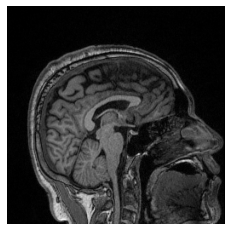

CC0174_siemens_15_41_M.nii (256, 256)


In [3]:
# Carregando uma imagem aleatória

img, file_name = loadRandomImage()
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()
print(file_name, img.shape)

In [54]:
# Definindo o processo de watershed que passamos a usar no teste 3

def watershedFromPoint(img, target_x, target_y, plot=False):
    # Watershed
    n_mean = 5
    mean_filter = 1/(n_mean**2)*np.ones((n_mean, n_mean))
    mean_img = skf.edges.convolve(img, mean_filter)
    
    target_value = mean_img[target_y, target_x]
    
    threshold_img = np.ones(img.shape, np.int8)
    lower_limit, upper_limit = max(target_value-20, 0), min(target_value+20, 255)
    threshold_img[img < lower_limit] = 0
    threshold_img[img > upper_limit] = 0

    distance = ndi.distance_transform_edt(threshold_img)

    markers = np.zeros(distance.shape, dtype=bool) 
    markers = (distance==0)*1
    markers[target_y, target_x] = 2

    labels = watershed(-distance, markers)

    # Removendo objetos pequenos e buracos
    f0 = remove_small_holes(labels-1, 64)
    final = remove_small_objects(f0, min_size=300)

    # Plot
    if plot:
        fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[1].imshow(threshold_img, cmap=plt.cm.gray)
        ax[1].set_title('Threshold')
        ax[2].imshow(distance, cmap=plt.cm.gray)
        ax[2].set_title('Distance')
        ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[3].set_title('Watershed')
        ax[4].imshow(final, cmap=plt.cm.gray)
        ax[4].set_title('Final')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return final

In [45]:
# Definindo função que retorna um ponto pertencente ao CC

def getCCPosition(f, plot=False):
    height, width = f.shape
    center_x = width//2
    center_y = height//2
    x_min, x_max = max(center_x-50, 0), min(center_x+50, width)
    y_min, y_max = 75, center_y
    
    cc_img = f[y_min:y_max, x_min:x_max]
    height, width = cc_img.shape
    
    n_mean=11
    mean_img = skf.edges.convolve(cc_img, np.ones((n_mean,n_mean))/n_mean**2)
    mean_img_id_max = np.argmax(mean_img)
    
    cc_y = mean_img_id_max//width
    cc_x = mean_img_id_max%width
    
    # Plot
    if plot:
        fig, axes = plt.subplots(ncols=2, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(cc_img, cmap=plt.cm.gray)
        ax[0].set_title('CC Region')
        ax[1].imshow(mean_img, cmap=plt.cm.gray)
        ax[1].scatter(cc_x, cc_y, cmap='red')
        ax[1].set_title('CC Position')
        for a in ax:
            a.set_axis_off()
        fig.tight_layout()
        plt.show()
    
    return cc_x+x_min, cc_y+y_min

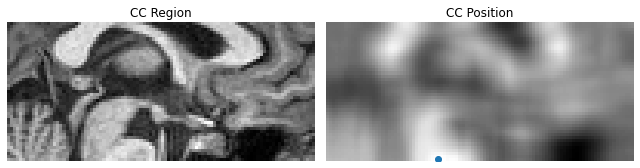

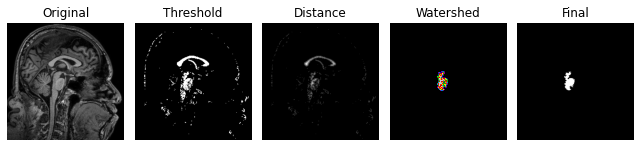

In [53]:
cc_x, cc_y = getCCPosition(img, plot=True)
cc = watershedFromPoint(img, cc_x, cc_y, plot=True)